# Time Series Analysis

In [3]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [4]:
ads = pd.read_csv('../../datasets/time_series/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('../../datasets/time_series/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [5]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


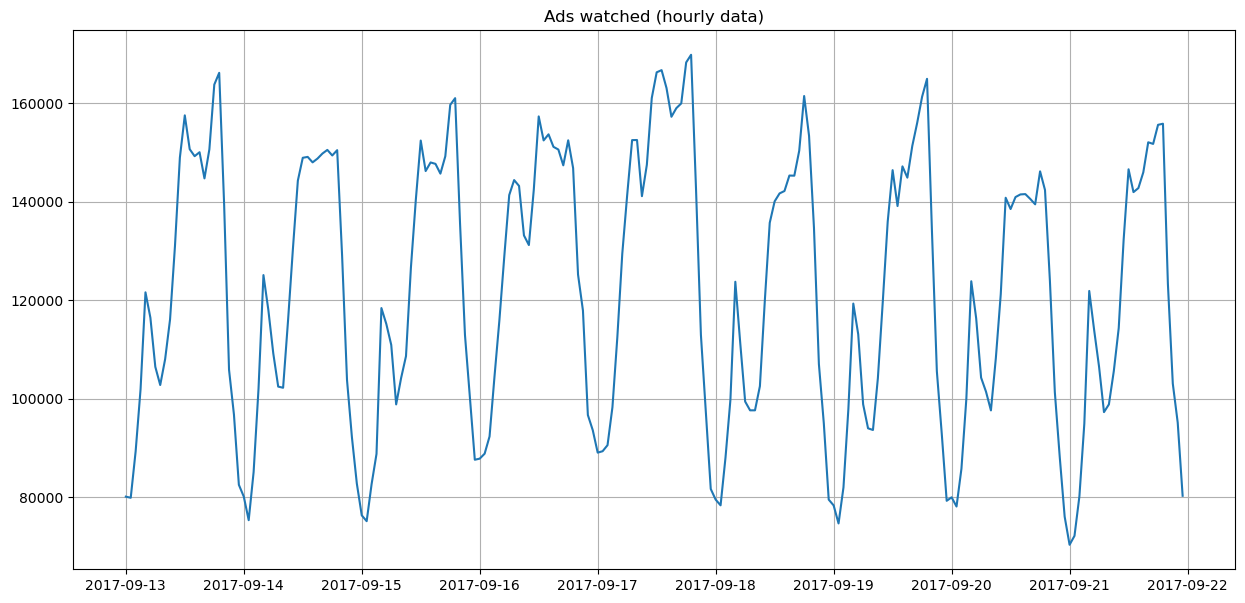

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

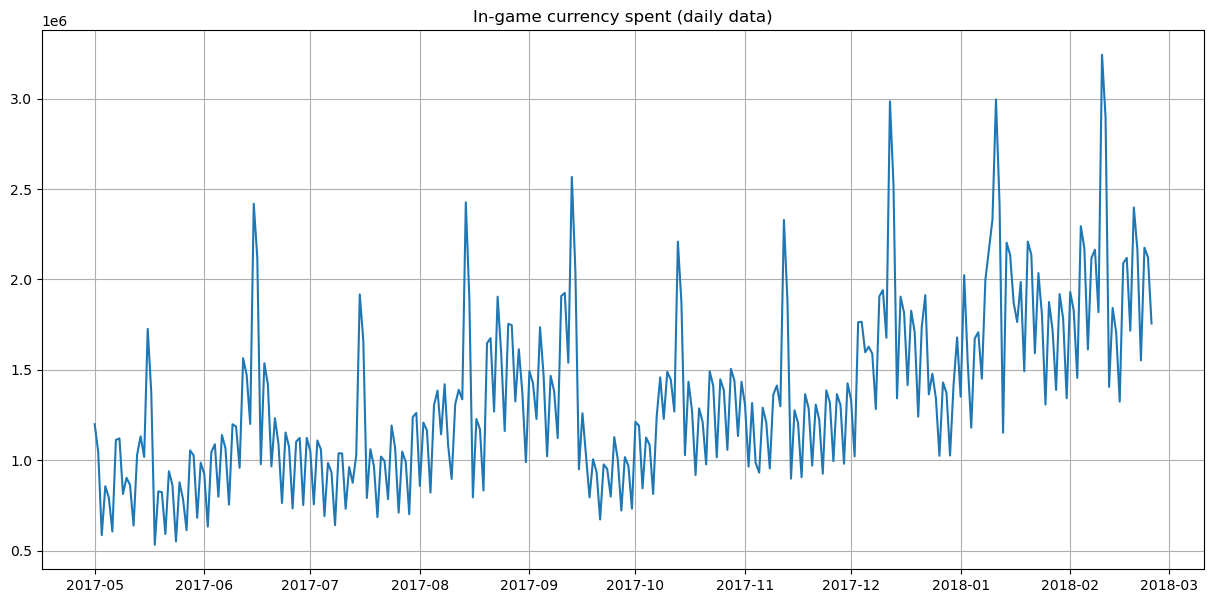

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## Evaluation Metrics

In [8]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Moving Average

In [9]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

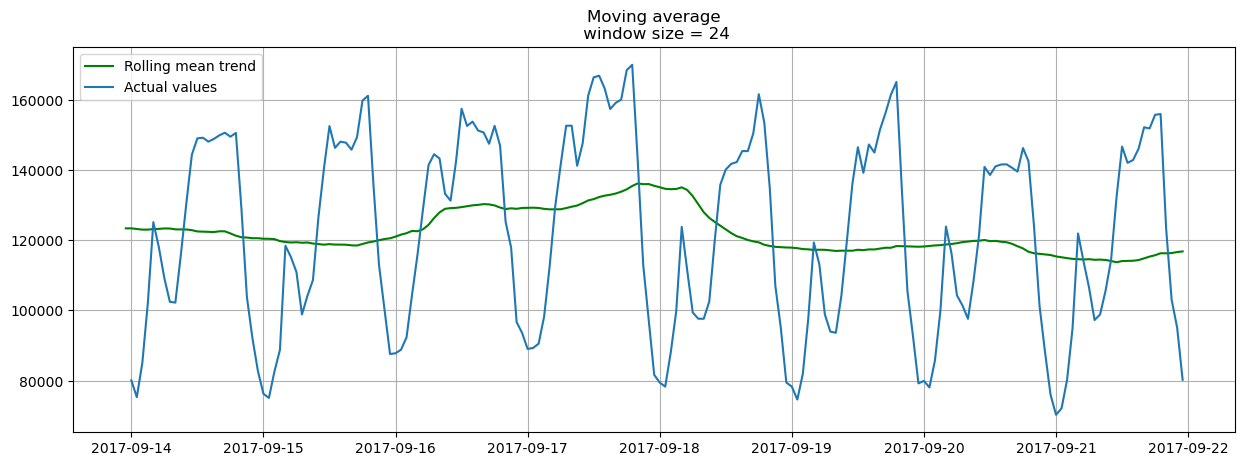

In [10]:
plotMovingAverage(ads, 24) # 24h average
# people see more ads on the weekend

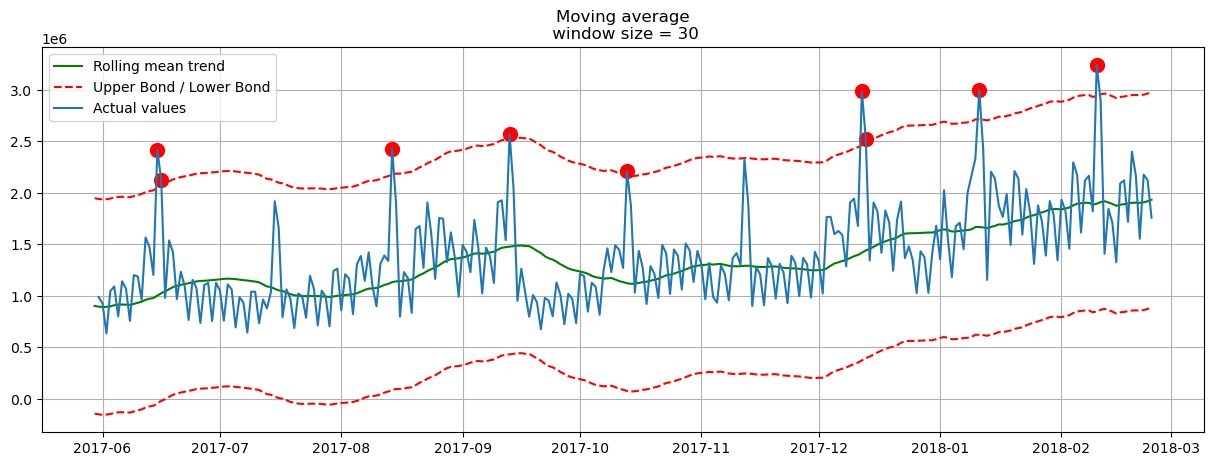

In [11]:
plotMovingAverage(currency, 30, plot_intervals=True, plot_anomalies=True) # weekly smoothing for currency

Moving average is not modeling the monthly seasonality of the currency data. We need a more complex model!

## Holt-Winters or 3rd degree exponential smoothing

In [12]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Cross Validation with Time Series

In [13]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

#### Optimize timeseriesCVscore to find the best alpha, beta and gamma values for the HoltWinters model

In [14]:
def HoltWinters_trainer(data, loss_function=mean_squared_log_error, slen=24, n_preds=50, scaling_factor=1.96):
  # initializing model parameters alpha, beta and gamma
  x = [0,0,1e-5] 


  # Minimizing the loss function 
  opt = minimize(timeseriesCVscore, 
                x0=x, 
                args=(data, loss_function, slen), 
                method="TNC", bounds = ((0, 1), (0, 1), (1e-5, 1))
                )

  # Take optimal values...
  alpha_final, beta_final, gamma_final = opt.x
  print(f"aplha: {alpha_final}, beta: {beta_final}, gamma: {gamma_final}")

  # ...and train the model with them, forecasting for the next n_preds steps
  model = HoltWinters(data, 
                      slen = slen, 
                      alpha = alpha_final, 
                      beta = beta_final, 
                      gamma = gamma_final, 
                      n_preds = n_preds, 
                      scaling_factor = scaling_factor)
  model.triple_exponential_smoothing()
  return model

data = ads.Ads[:-20] # leave some data for testing
ads_model = HoltWinters_trainer(data, scaling_factor=3)


aplha: 0.1166282024207822, beta: 0.0026969816013768244, gamma: 0.052530110672430685


### Let's plot the results

In [15]:
def plotHoltWinters(series, model, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

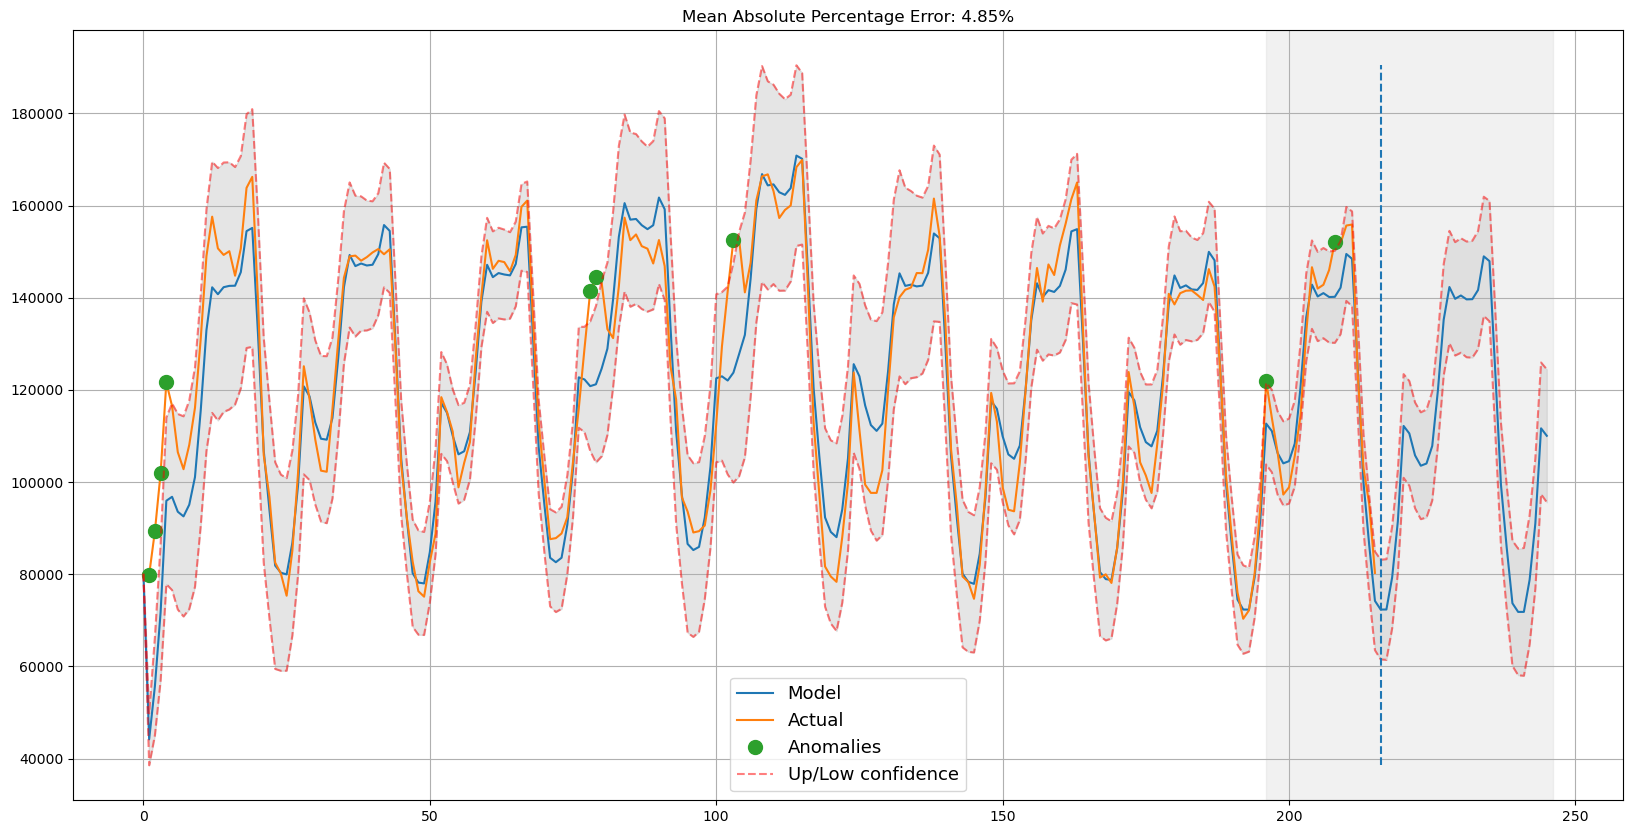

In [16]:
plotHoltWinters(ads.Ads, ads_model, plot_intervals=True, plot_anomalies=True)

Brutlag's deviation

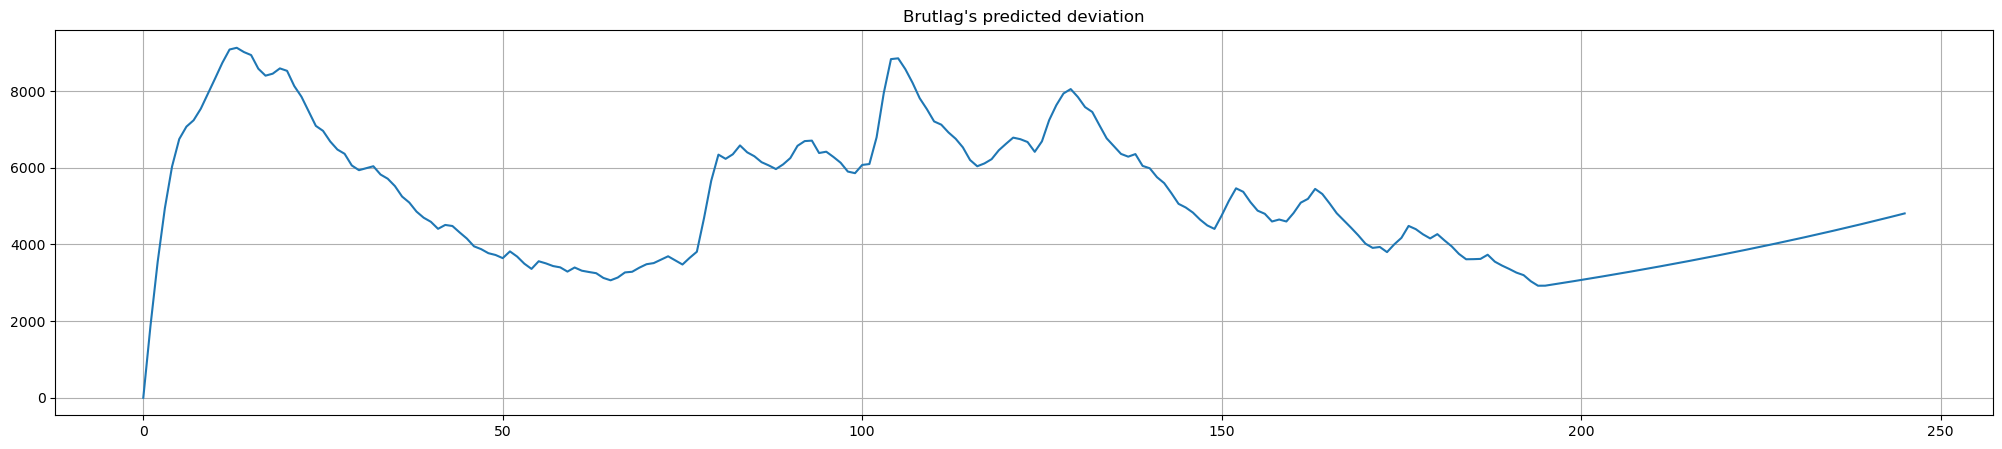

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(ads_model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

For Currency

aplha: 0.01282769475183243, beta: 0.04859747996538971, gamma: 0.009769799639823051


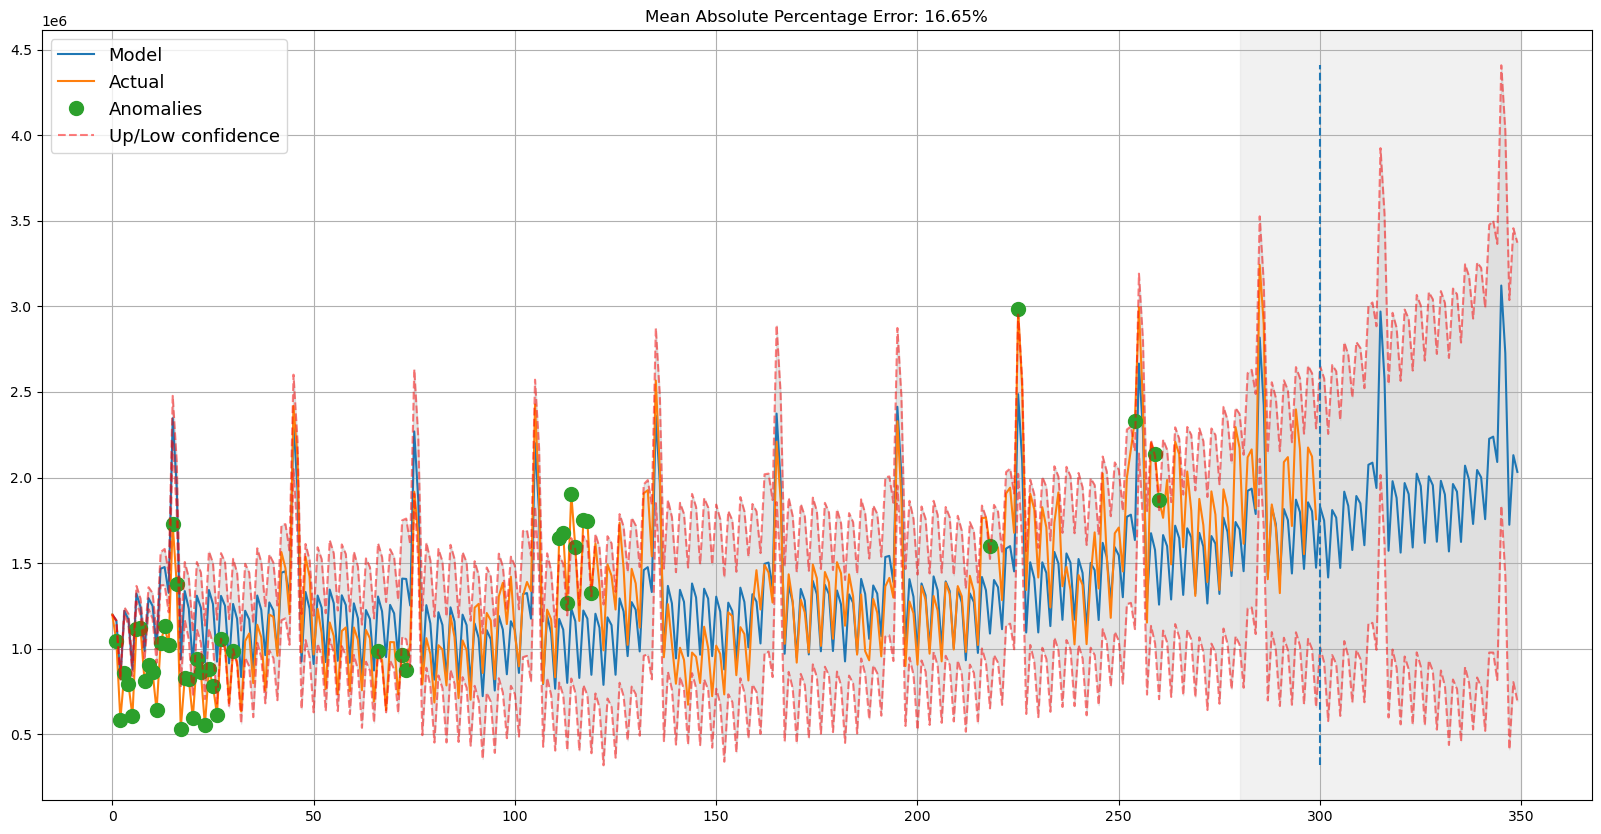

In [18]:
data = currency.GEMS_GEMS_SPENT[:-50] # leave some data for testing
currency_model = HoltWinters_trainer(data, loss_function=mean_absolute_percentage_error, slen=30, n_preds=100, scaling_factor=3) # 30 days seasonality
plotHoltWinters(currency.GEMS_GEMS_SPENT, currency_model, plot_intervals=True, plot_anomalies=True)

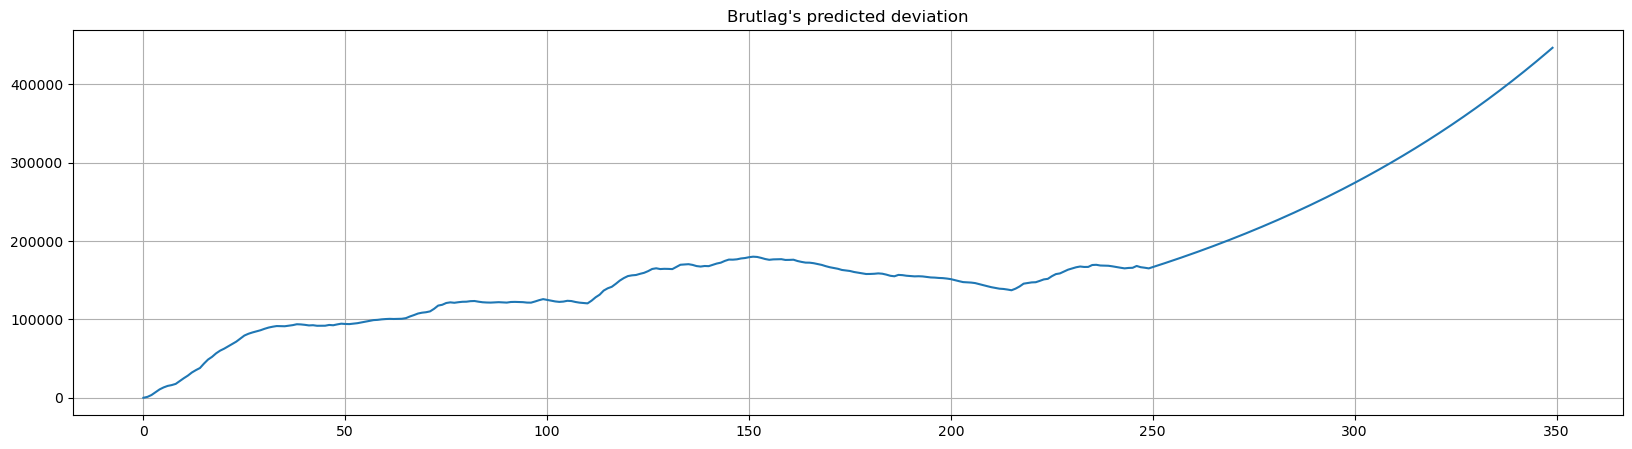

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(currency_model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# SARIMA and Non-Stationarity

In [20]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

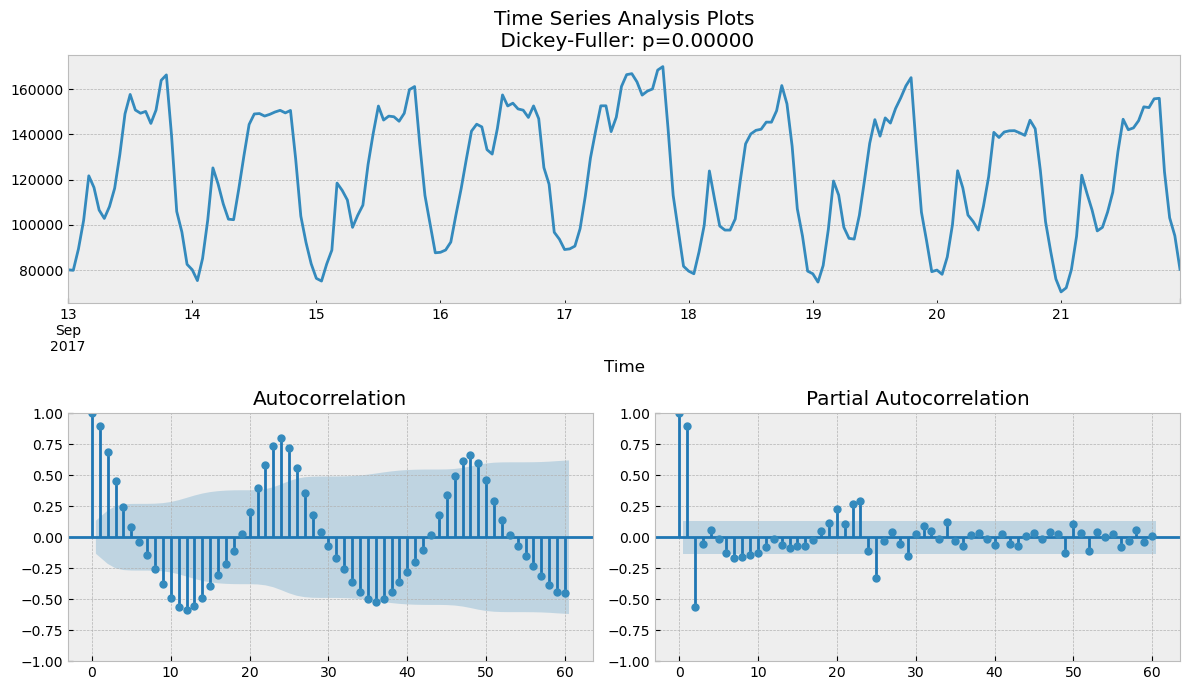

In [21]:
tsplot(ads.Ads, lags=60)

The serie is stationary as we can see the Dickey-Fuller test p value is 0 so the null hypothesis is rejected.

However, we still have seasonality that we need to get rid of.

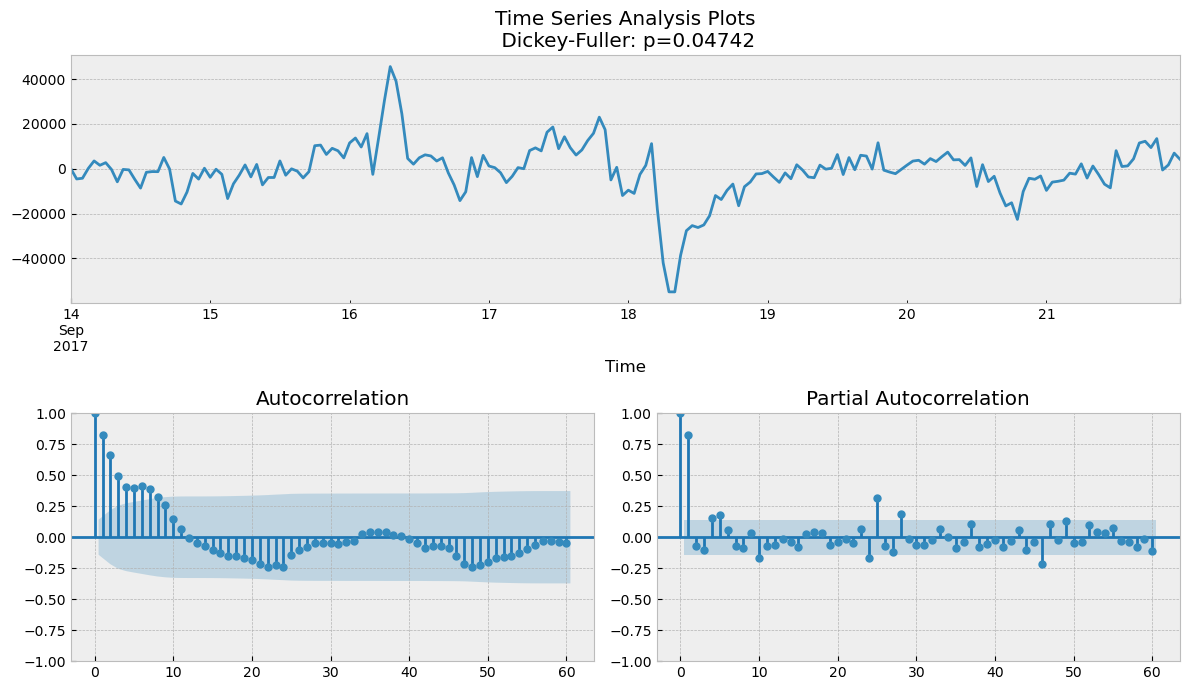

In [22]:
slen = 24
ads_diff = ads.Ads - ads.Ads.shift(slen)
tsplot(ads_diff[slen:], lags=60)

Now the seasonality is gone. But the Autocorelation function still has too many significant lags, so we need to take the first degree difference:

Substract the series from itself with lag 1.

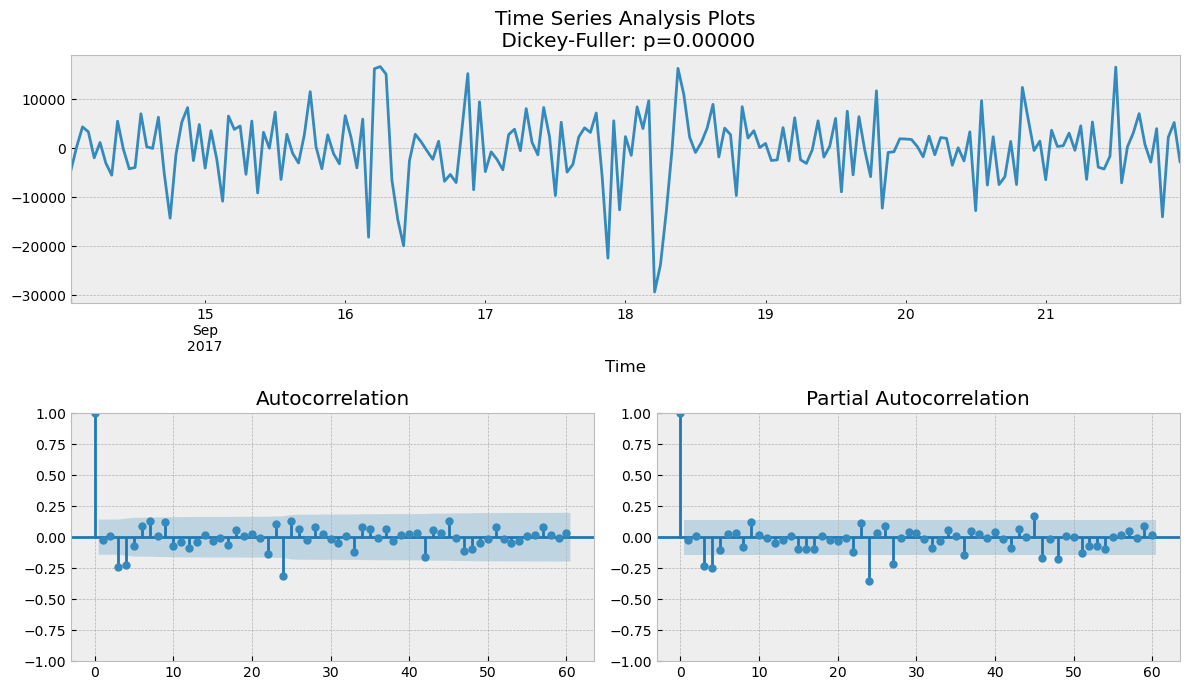

In [23]:
d = 1
ads_diff = ads_diff - ads_diff.shift(d)
tsplot(ads_diff[slen+d:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

### ARIMA crash-course

We will explain this model by building up letter by letter.  SARIMA(p,d,q)(P,D,Q,s)
 , Seasonal Autoregression Moving Average model:

AR(p)
  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p
 . To determine the initial  p
 , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.
MA(q)
  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q
 . The initial value can be found on the ACF plot with the same logic as before.
Let's combine our first 4 letters:

AR(p)+MA(q)=ARMA(p,q)
 
What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

I(d)
  - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the  ARIMA
  model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

S(s)
  - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters:  (P,D,Q)
 
P
  - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial  P
  should be 2.

Q
  - similar logic using the ACF plot instead.

D
  - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

- p is most probably 4 since it is the last significant lag on the PACF, after which, most others are not significant.
- d equals 1 because we had first differences
- q should be somewhere around 4 as well as seen on the ACF
- P might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- D again equals 1 because we performed seasonal differentiation
- Q is probably 1. The 24-th lag on ACF is significant while the 48-th is not.

In [24]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [28]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [29]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

/Users/clement/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/clement/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/clement/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/clement/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/clement/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was 

In [30]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [31]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/Users/clement/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/clement/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Thu, 15 Aug 2024   AIC                           3888.642
Time:                                      23:12:07   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

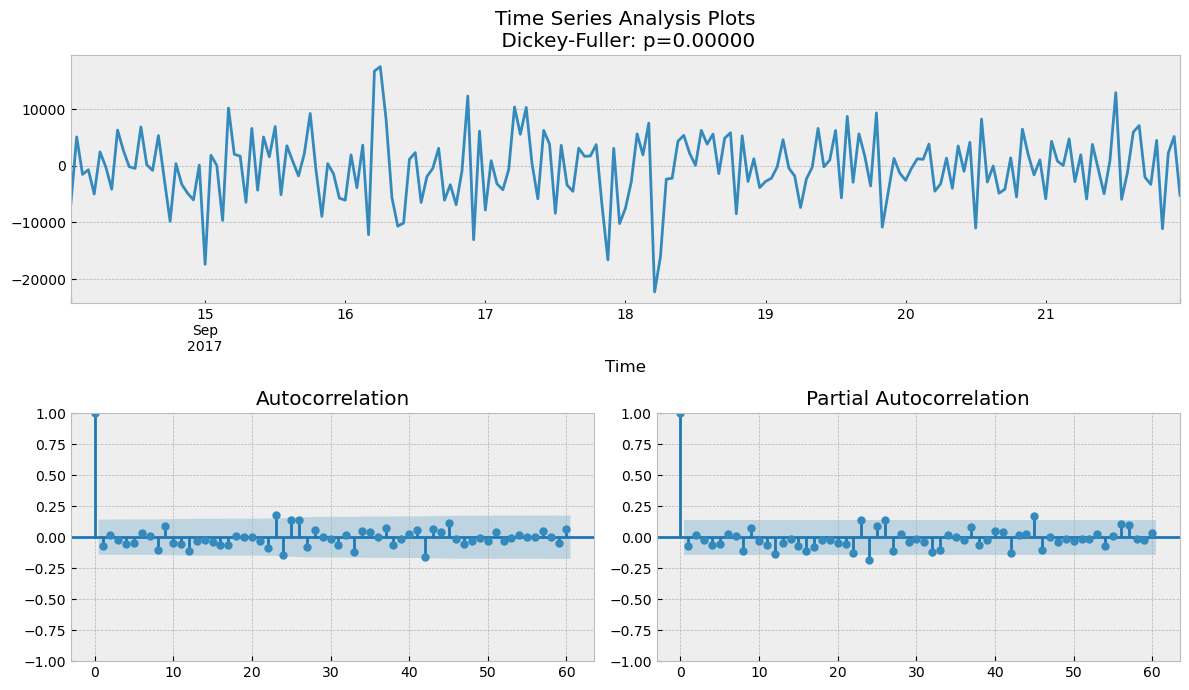

In [32]:
# inspect the residuals of the model for stationarity
tsplot(best_model.resid[24+1:], lags=60)

It is clear that the residuals are stationary, and there are no apparent autocorrelations.

In [33]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

Exception ignored in: <function tqdm.__del__ at 0x17c0b0280>
Traceback (most recent call last):
  File "/Users/clement/anaconda3/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/clement/anaconda3/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


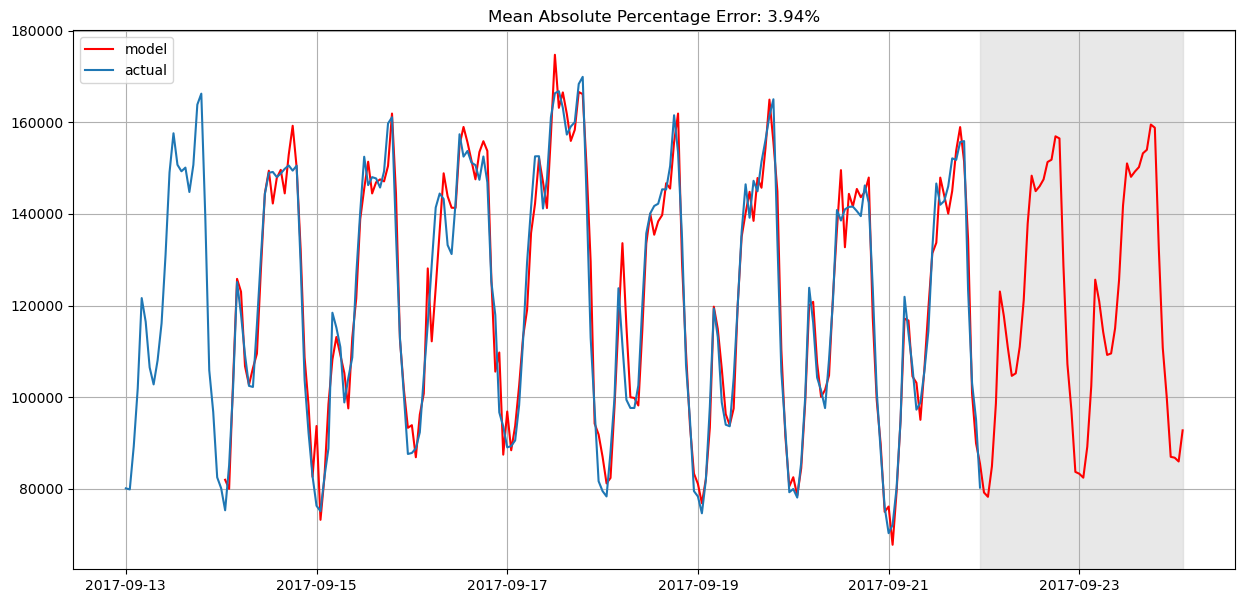

In [34]:
plotSARIMA(ads, best_model, 50)

Less than 4% error!

In [39]:
best_model.specification

{'seasonal_periods': 24,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': (2, 1, 3),
 'seasonal_order': (1, 1, 1, 24),
 'k_diff': 1,
 'k_seasonal_diff': 1,
 'k_ar': 2,
 'k_ma': 3,
 'k_seasonal_ar': 24,
 'k_seasonal_ma': 24,
 'k_ar_params': 2,
 'k_ma_params': 3,
 'trend': None,
 'k_trend': 0,
 'k_exog': 0,
 'mle_regression': False,
 'state_regression': False}

# Linear Models on Time Series

In [58]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [51]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)


def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');


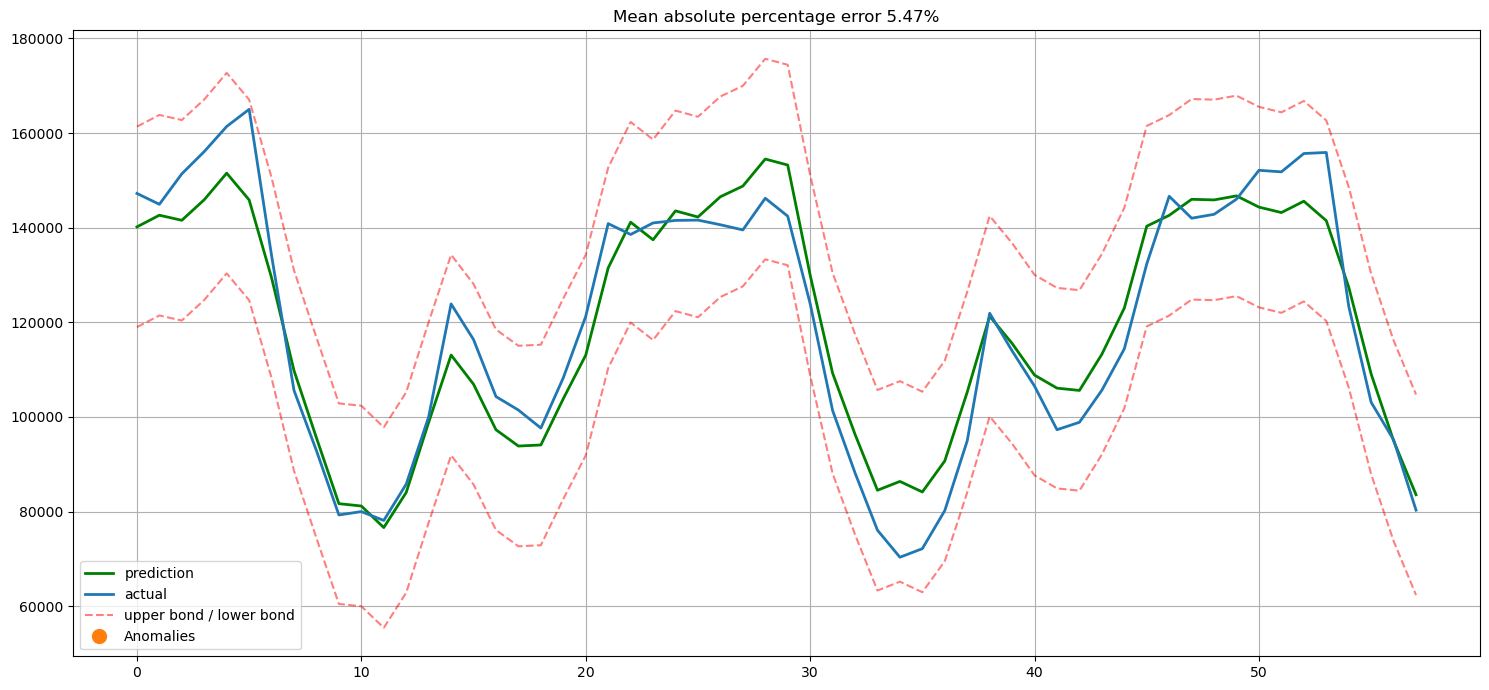

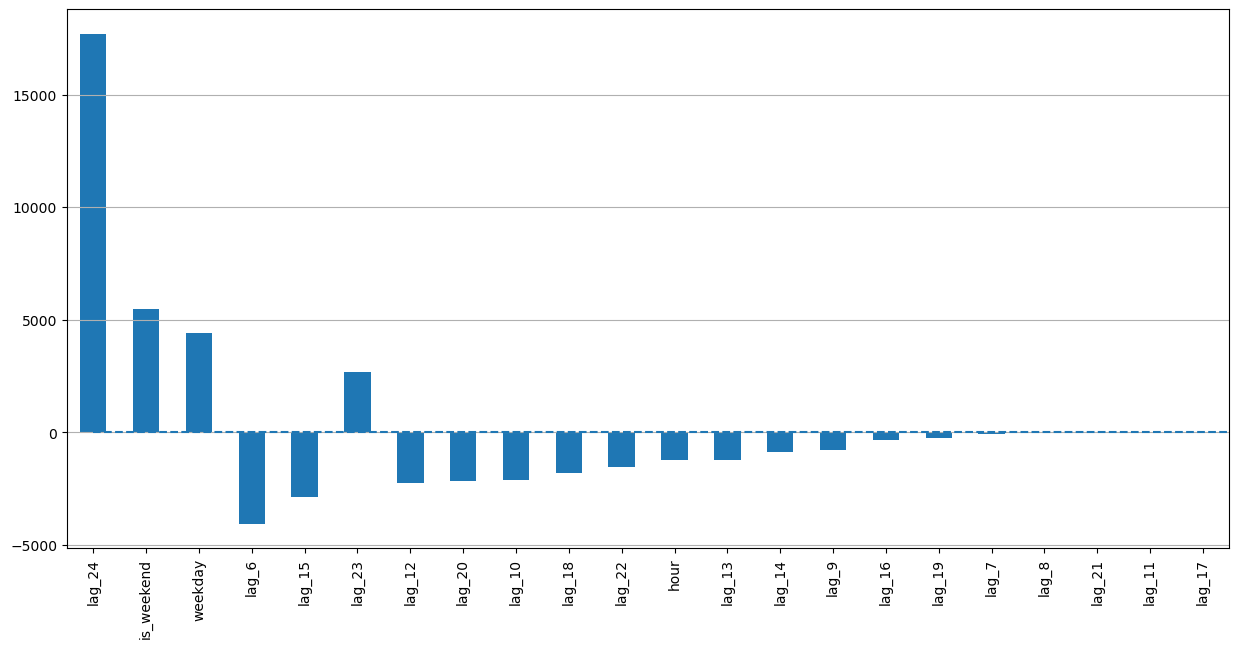

In [60]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LassoCV(cv=tscv)
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr, X_train=X_train)

## Boosting

In [99]:
from xgboost import XGBRegressor 

X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4, n_estimators=100, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, min_child_weight=1,objective='reg:linear', n_jobs=1,random_state=0,seed=None, silent=True,
       subsample=1, nthread=None,)

xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=1, nthread=None, num_parallel_tree=None, ...)

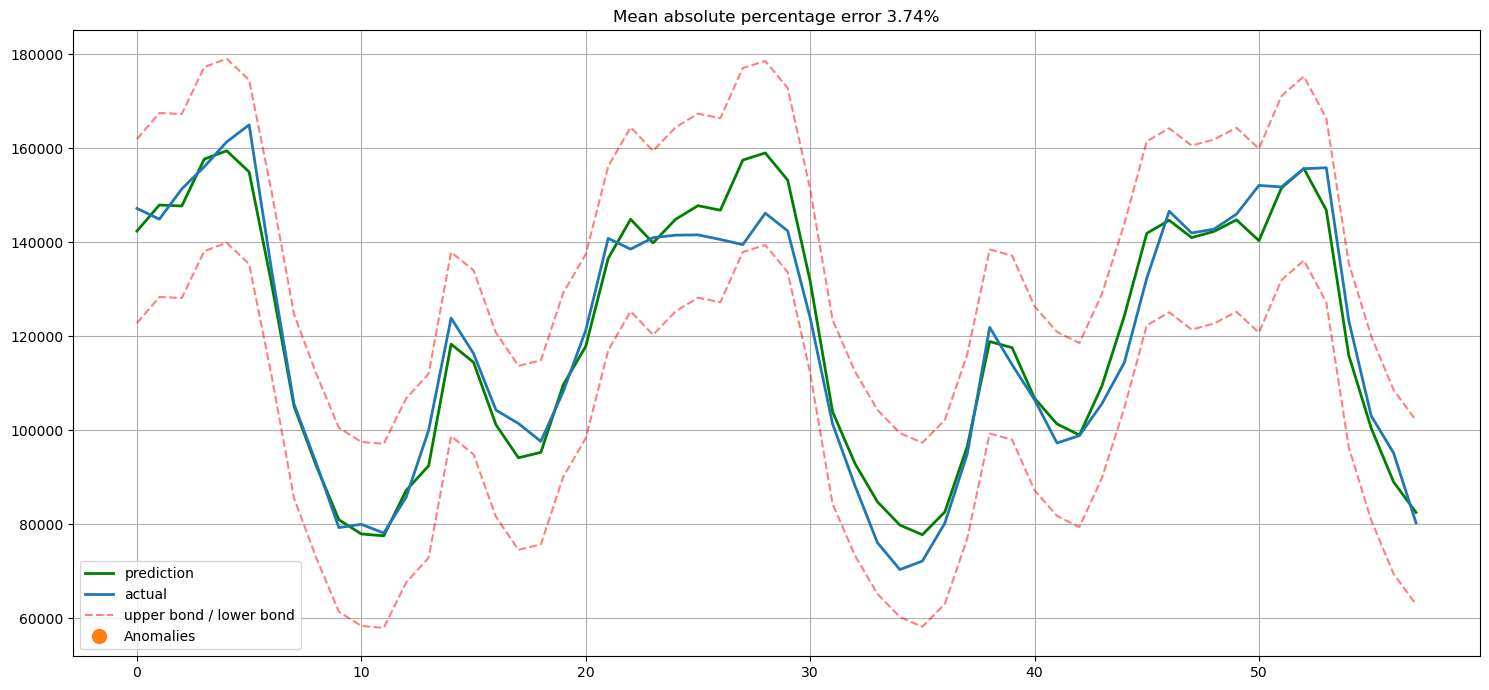

In [100]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 y_train=y_train, y_test=y_test,
                 plot_intervals=True, plot_anomalies=True)

It's a better model than ARIMA!